| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | $$\text{Pa}\cdot\text{s}$$ | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient (coupling tissue & vessel) |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow (Robin) permeability                 |
| $$ \gamma_a $$ | $$\text{m}$$                    | Terminal vessel coupling length scale (hydraulic conductance at end) |

In [52]:
%%capture
!pip install numpy==1.26.4
!pip install ipywidgets vtk meshio pyvista Rtree

In [53]:
import sys, os, importlib

WORK_PATH = "/root/3d-1d"
MODULES_PATH = os.path.join(WORK_PATH, 'modules')

sys.path.append(MODULES_PATH)

In [54]:
from graphnics import FenicsGraph

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],   # A
    1: [0.010, 0.020, 0.015],   # B
    2: [0.022, 0.013, 0.015],   # C
    3: [0.022, 0.028, 0.015],   # D
    4: [0.015, 0.005, 0.015],   # E
    5: [0.015, 0.035, 0.015],   # F
    6: [0.038, 0.005, 0.015],   # G
    7: [0.038, 0.035, 0.015]    # H
}

TEST_GRAPH_EDGES = [
    (0, 1, 0.004),  # AB
    (1, 2, 0.003),  # BC
    (1, 3, 0.003),  # BD
    (2, 4, 0.002),  # CE
    (2, 6, 0.003),  # CG
    (3, 5, 0.002),  # DF
    (3, 7, 0.003)   # DH
]

TEST_GRAPH = FenicsGraph()

for node, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node, pos=pos)

for u, v, radius in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

In [88]:
import FEMSinkVelo
importlib.reload(FEMSinkVelo)

VTEST = FEMSinkVelo.FEMSinkVelo(
    G = TEST_GRAPH,
    gamma = 1.45e8,
    gamma_R = 1300,
    gamma_v = 25,
    gamma_a = 2,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.5e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0]
)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2647.01it/s]


Applied BC! Non-empty list


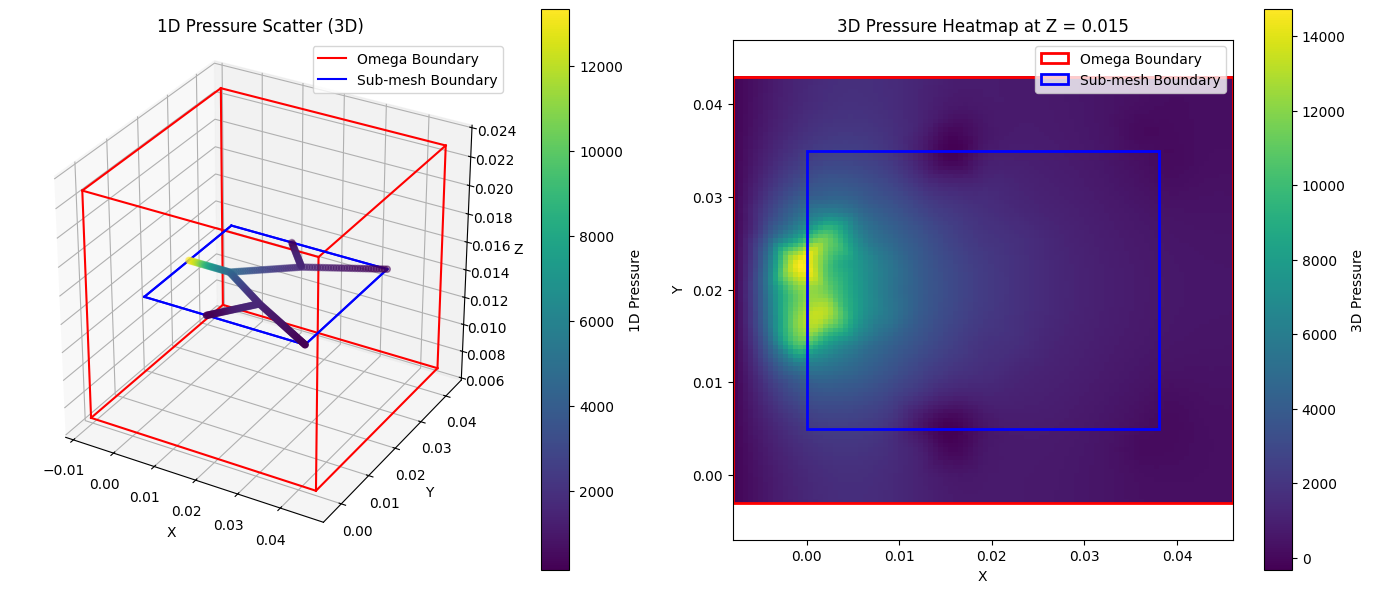

In [94]:
import Visualizer
importlib.reload(Visualizer)

Visualizer.plot_with_boundaries(VTEST.uh1d, VTEST.uh3d)

Node Pressure Data:
Node 0: Pressure 13332.2
Node 113: Pressure 13169.7
Node 57: Pressure 12973.8
Node 114: Pressure 12763.5
Node 29: Pressure 12513.9
Node 116: Pressure 12264.3
Node 58: Pressure 12014.7
Node 115: Pressure 11724.8
Node 15: Pressure 11273.8
Node 119: Pressure 10822.8
Node 60: Pressure 10371.9
Node 120: Pressure 9923.7
Node 30: Pressure 9482.5
Node 118: Pressure 9038.5
Node 59: Pressure 8654.4
Node 117: Pressure 8308.2
Node 8: Pressure 7962.0
Node 125: Pressure 7615.7
Node 63: Pressure 7328.6
Node 126: Pressure 7130.3
Node 32: Pressure 6931.9
Node 128: Pressure 6733.6
Node 64: Pressure 6533.4
Node 127: Pressure 6324.6
Node 16: Pressure 6116.3
Node 123: Pressure 5925.0
Node 62: Pressure 5738.3
Node 124: Pressure 5551.6
Node 31: Pressure 5365.0
Node 122: Pressure 5211.4
Node 61: Pressure 5079.8
Node 121: Pressure 4948.3
Node 1: Pressure 4816.8
Node 145: Pressure 4635.9
Node 73: Pressure 4464.0
Node 146: Pressure 4322.0
Node 37: Pressure 4191.9
Node 148: Pressure 4061.8
Nod

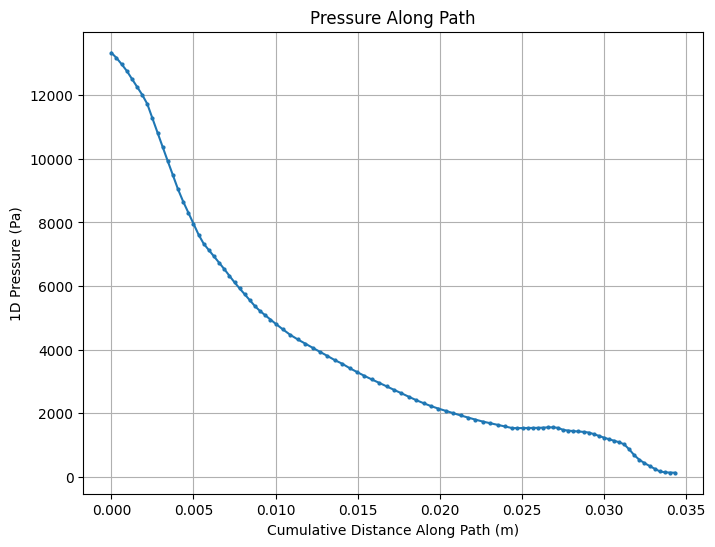

In [95]:
importlib.reload(Visualizer)
Visualizer.plot_path_pressure(VTEST.uh1d, TEST_GRAPH, [0, 1, 3, 5])

In [96]:
import FEMSinkCubeFlux
import numpy as np
importlib.reload(FEMSinkCubeFlux)

CUBE_TEST = FEMSinkCubeFlux.FEMSinkCubeFlux(
    G = TEST_GRAPH,
    gamma = 1.45e8,
    gamma_R = 1300,
    gamma_v = 25,
    gamma_a = 2,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.5e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Lambda_padding_min = 0.008,
    upper_cube_bounds = [np.array(TEST_GRAPH_NODES[6]) - np.array([0.005, 0.005, 0.005]),
                         np.array(TEST_GRAPH_NODES[6]) + np.array([0.005, 0.005, 0.005])]
)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2725.01it/s]


Applied BC! Non-empty list


Lower Cube Bounds: [[-0.008, -0.003, 0.006999999999999999], [0.0, 0.005, 0.015]]
Upper Cube Bounds: [array([0.033, 0.   , 0.01 ]), array([0.043, 0.01 , 0.02 ])]


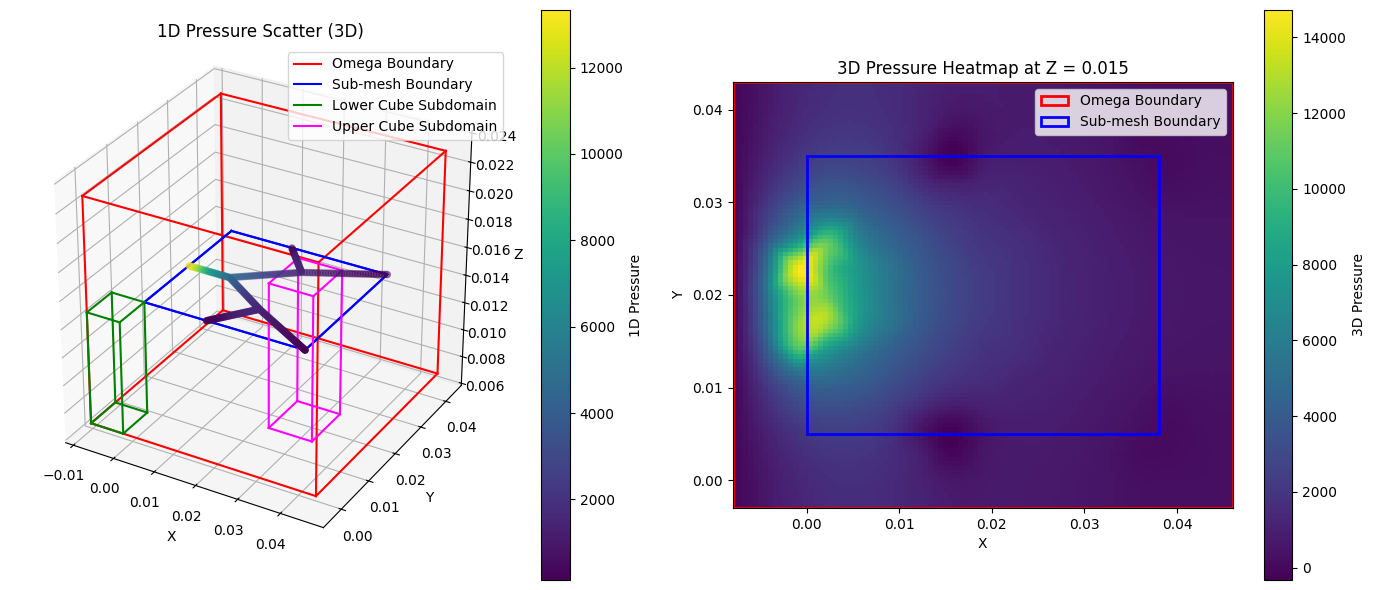

In [109]:
importlib.reload(Visualizer)
cube_lower_bounds = CUBE_TEST.lower_cube_bounds
cube_upper_bounds = CUBE_TEST.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

Visualizer.plot_with_boundaries(CUBE_TEST.uh1d, CUBE_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)

In [110]:
CUBE_TEST.compute_upper_cube_flux()

0.0